# Imports

In [109]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [110]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [111]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [112]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [113]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [114]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[34.42769405 34.4365603  34.42777995 ... 10.81577237 31.03638597
 10.81760085]
[27.44355595 27.45062356 27.44362442 ...  8.62164203 24.74022203
  8.62309958]
[0.99999983 0.99999983 0.99999983 ... 0.99254656 0.9999992  0.99255268]
(5999,)


### Multinomial Sampling

In [115]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [116]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.98231, -5.5423326, 82.901405), (51.0, 4.0099483, 82.16672), (80.22376, 8.78582, 87.65081), (39.0, 4.590885, 82.49242), (90.10597, 1.6554987, -4.9214387), (83.13447, -8.774797, 42.5), (78.62658, 1.6554987, -13.261708), (75.601654, -3.2518802, 3.6387866), (77.72867, 1.6554987, -13.428126), (86.77158, 5.2797017, 91.79918), (75.177315, -6.9390492, 84.583374), (78.98692, -8.447791, 86.12344), (90.52928, 5.670694, 29.6), (51.0, 8.743327, 89.00289), (39.0, 8.743327, 89.00289), (80.67663, 5.2797017, -10.988123), (86.09374, 7.8332825, 87.60497), (87.303505, -4.1574683, 92.27812), (63.0, 8.492921, 92.304405), (76.97676, 8.722893, -3.5773659), (87.358986, 8.048206, 29.6), (78.21332, -8.798424, -4.570979), (78.1065, 8.722893, -3.177305), (78.4674, 8.722893, -3.0051613), (75.74507, 6.5098743, 1.0193683), (88.439125, 2.3044074, -7.082788), (39.0, 8.294318, 92.94012), (87.893486, 6.7292814, 87.769554), (80.24101, 8.048206, 29.6), (80.11056, 8.722893, -1.8758512), (75.67042, -7.8332825, -8.992393

# KNN

In [117]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.98231, -5.5423326, 82.901405], [51.0, 4.0099483, 82.16672], [80.22376, 8.78582, 87.65081], [39.0, 4.590885, 82.49242], [90.10597, 1.6554987, -4.9214387], [83.13447, -8.774797, 42.5], [78.62658, 1.6554987, -13.261708], [75.601654, -3.2518802, 3.6387866], [77.72867, 1.6554987, -13.428126], [86.77158, 5.2797017, 91.79918], [75.177315, -6.9390492, 84.583374], [78.98692, -8.447791, 86.12344], [90.52928, 5.670694, 29.6], [51.0, 8.743327, 89.00289], [39.0, 8.743327, 89.00289], [80.67663, 5.2797017, -10.988123], [86.09374, 7.8332825, 87.60497], [87.303505, -4.1574683, 92.27812], [63.0, 8.492921, 92.304405], [76.97676, 8.722893, -3.5773659], [87.358986, 8.048206, 29.6], [78.21332, -8.798424, -4.570979], [78.1065, 8.722893, -3.177305], [78.4674, 8.722893, -3.0051613], [75.74507, 6.5098743, 1.0193683], [88.439125, 2.3044074, -7.082788], [39.0, 8.294318, 92.94012], [87.893486, 6.7292814, 87.769554], [80.24101, 8.048206, 29.6], [80.11056, 8.722893, -1.8758512], [75.67042, -7.8332825, -8.992393

In [118]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [119]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  15


Number of nodes: 50
Number of edges: 527


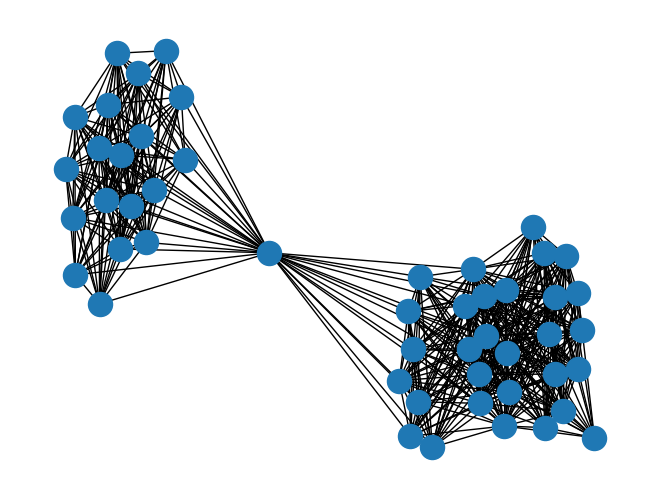

In [120]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [121]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [ ]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""

### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh